In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import fpl_functions as fpl
pd.options.mode.chained_assignment = None
sns.set_theme()

In [81]:
GAMEWEEKS_PLAYED = 5

In [82]:
df = pd.read_excel('data/players_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))
fixtures = pd.read_excel('data/fixtures.xlsx')
my_team = pd.read_excel('data/my_team_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))

In [83]:
my_team

,Players,multiplier,is_captain,is_vice_captain
0,Henderson,1,False,False
1,Pedro Porro,1,False,False
2,Robinson,1,False,False
3,Alexander-Arnold,1,False,False
4,Johnson,1,False,False
5,Eze,1,False,False
6,Souček,1,False,False
7,M.Salah,2,True,False
8,Haaland,1,False,True
9,João Pedro,1,False,False


In [84]:
df.loc[df['position'] == 'Goalkeeper'].groupby('team')['expected_goals_conceded'].sum().sort_values()

team
Man City           3.64
Liverpool          3.69
Nott'm Forest      3.98
Bournemouth        4.81
Spurs              5.12
Aston Villa        5.19
Chelsea            5.76
Fulham             5.79
Brighton           5.84
Man Utd            6.39
Wolves             6.78
Crystal Palace     8.18
Leicester          8.21
Newcastle          8.54
Everton            8.86
Arsenal            9.39
Southampton        9.84
West Ham          10.11
Brentford         11.08
Ipswich           11.09
Name: expected_goals_conceded, dtype: float64

In [85]:
df.drop(df[df['status'].isin(['d', 'i', 's', 'u'])].index, inplace=True)
df = df.drop(df[df['minutes'] == 0].index)

df['now_cost'] = df['now_cost']/10

#create points per million (cost) column (ppm)
df['ppm'] = round(df['total_points']/df['now_cost'], 2)

df['goal_involvements'] = df['goals_scored'] + df['assists']
#create expected goals and goal involvements vs actual goals and goal involvements columns
df['g_vs_xg'] = df['goals_scored'] - df['expected_goals']
df['gi_vs_xgi'] = df['goal_involvements'] - df['expected_goal_involvements']

df['points_per_minute'] = df['total_points']/df['minutes']

df['gc_vs_xgc'] = df['goals_conceded'] - df['expected_goals_conceded']

df['percent_of_season_played'] = np.round(df['minutes']/(GAMEWEEKS_PLAYED*90) * 100, 2)
#drop players who've played less than half the season up until now
df = df.drop(df[df['percent_of_season_played'] < 50].index)

#expected goal involvements per million; could this be a good way to determine which players are "undervalued"?
df['xgi_pm'] = round(df['expected_goal_involvements']/df['now_cost'], 2)
df['xg_pm'] = round(df['expected_goals']/df['now_cost'], 2)
df['xa_pm'] = round(df['expected_assists']/df['now_cost'], 2)

In [86]:
fixtures_going_forward = fixtures.loc[fixtures['Gameweek'] > GAMEWEEKS_PLAYED]

df['next_match'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED+1)[['opponent', 'h_or_a']].iloc[-1]))
df['next_5_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+5)['FDR']))
#df['past_3_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED)['FDR']))
df['next_5_avg_FDRs'] = df['next_5_FDRs'].apply(lambda x: np.round(np.mean(x), 2))
#df['past_3_avg_FDRs'] = df['past_3_FDRs'].apply(lambda x: np.mean(x))

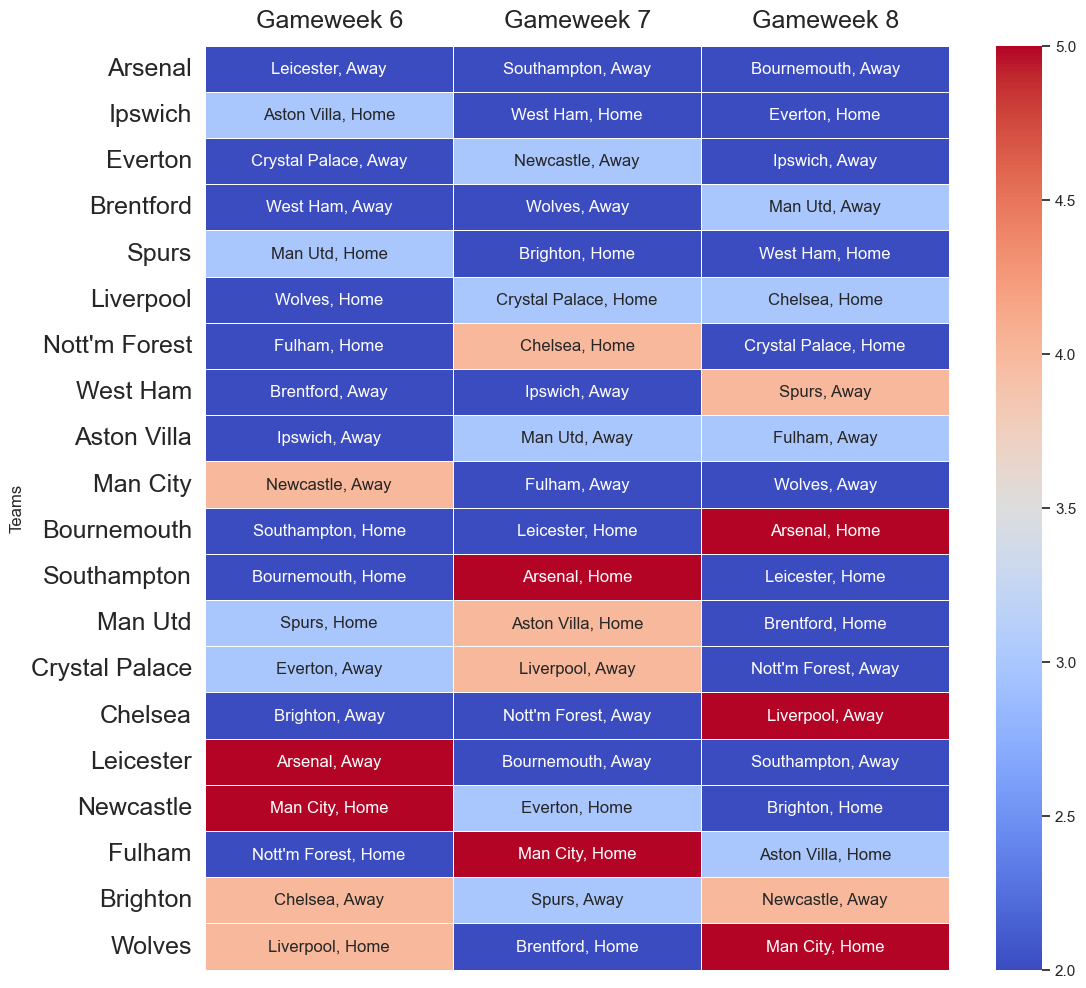

In [87]:
pl_teams = fixtures['team_h'].unique()
fixture_matrix_fdr = pd.DataFrame({'Teams': pl_teams})
fixture_matrix_fdr['next_5_fdr'] = fixture_matrix_fdr['Teams'].apply(lambda x: fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+3)['FDR'].mean())
fixture_matrix_fdr.sort_values(by='next_5_fdr', ascending=True, inplace=True)
fixture_matrix_fdr.drop('next_5_fdr', axis=1, inplace=True)

fixture_matrix_matches = fixture_matrix_fdr.copy()

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        fdr = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['FDR'].values[i-GAMEWEEKS_PLAYED]
        gw_fix.append(fdr)
    fixture_matrix_fdr['Gameweek {}'.format(i+1)] = gw_fix

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        opponent = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['opponent'].values[i-GAMEWEEKS_PLAYED]
        h_or_a = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['h_or_a'].values[-1]
        gw_fix.append('{}, {}'.format(opponent, h_or_a))
    fixture_matrix_matches['Gameweek {}'.format(i+1)] = gw_fix

fig, ax = plt.subplots(figsize=(12,12)) 
ax = sns.heatmap(fixture_matrix_fdr.set_index('Teams'), annot=fixture_matrix_matches.set_index('Teams'), fmt='', linewidth=.5, cmap='coolwarm')
plt.tick_params(axis='both', which='major', labelsize=18, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

In [88]:
first_four_fixtures = pd.DataFrame()
for i in pl_teams:
    temp = fpl.fixtures_by_team(fixtures, i, GAMEWEEKS_PLAYED)
    first_four_fixtures = pd.concat([first_four_fixtures, temp])

first_4_fdrs = pd.DataFrame(first_four_fixtures.groupby('selected_team')['FDR'].sum().astype(int).sort_values(ascending=False)).reset_index()
first_4_fdrs.rename(columns={'selected_team': 'team'}, inplace=True)

#this won't count own goals scored
first_4_gi_xgi = pd.DataFrame(df.groupby('team')[['goals_scored', 'expected_goals', 'g_vs_xg']].sum().sort_values(by='expected_goals', ascending=False)).reset_index()

first_4_gi_xgi

,team,goals_scored,expected_goals,g_vs_xg
0,Man Utd,5,9.15,-4.15
1,Man City,11,8.97,2.03
2,Liverpool,9,8.62,0.38
3,Spurs,5,6.78,-1.78
4,Bournemouth,4,6.76,-2.76
5,Chelsea,9,6.32,2.68
6,Fulham,4,5.87,-1.87
7,Aston Villa,6,5.63,0.37
8,West Ham,3,5.17,-2.17
9,Brighton,5,5.09,-0.09


In [89]:
#join gi vs xgi and fdr tables for first 3 games
first_4_games_table = first_4_gi_xgi.merge(first_4_fdrs, on='team', how='left')
first_4_games_table['FDR'] = first_4_games_table['FDR'] - np.median(first_4_games_table['FDR'].unique())

first_4_games_table

,team,goals_scored,expected_goals,g_vs_xg,FDR
0,Man Utd,5,9.15,-4.15,-1.5
1,Man City,11,8.97,2.03,0.5
2,Liverpool,9,8.62,0.38,-3.5
3,Spurs,5,6.78,-1.78,0.5
4,Bournemouth,4,6.76,-2.76,1.5
5,Chelsea,9,6.32,2.68,-1.5
6,Fulham,4,5.87,-1.87,-2.5
7,Aston Villa,6,5.63,0.37,-1.5
8,West Ham,3,5.17,-2.17,2.5
9,Brighton,5,5.09,-0.09,0.5


In [90]:
fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', True, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
407,Ederson M.,Man City,5.5,8.2,69,100.0,3.45,"[Newcastle, Away]",2.4,1,11,5,3.64,1.36,19
163,Verbruggen,Brighton,4.5,2.1,50,60.0,2.22,"[Chelsea, Away]",3.6,1,9,3,3.96,-0.96,10
623,Johnstone,Wolves,4.4,0.5,17,60.0,1.36,"[Liverpool, Home]",3.0,0,8,6,3.98,2.02,6
512,Sels,Nott'm Forest,4.5,2.7,69,100.0,4.67,"[Fulham, Home]",2.4,2,11,4,3.98,0.02,21
590,Vicario,Spurs,5.0,3.6,75,100.0,2.80,"[Man Utd, Away]",2.6,1,12,5,5.12,-0.12,14
50,Martinez,Aston Villa,5.0,13.3,41,100.0,1.80,"[Ipswich, Away]",2.8,0,10,7,5.19,1.81,9
206,Sánchez,Chelsea,4.7,9.9,110,100.0,6.38,"[Brighton, Home]",3.0,2,21,5,5.76,-0.76,30
287,Leno,Fulham,5.0,2.6,60,100.0,2.60,"[Nott'm Forest, Away]",3.0,0,16,5,5.79,-0.79,13
446,Onana,Man Utd,5.0,5.8,108,100.0,6.00,"[Spurs, Home]",2.8,3,11,5,6.39,-1.39,30
523,Ramsdale,Southampton,4.4,2.1,32,60.0,1.82,"[Bournemouth, Away]",3.2,0,16,7,7.14,-0.14,8


In [91]:
fpl.top_players(df, 'Goalkeeper', 'ppm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
206,Sánchez,Chelsea,4.7,9.9,110,100.0,6.38,"[Brighton, Home]",3.0,2,21,5,5.76,-0.76,30
446,Onana,Man Utd,5.0,5.8,108,100.0,6.00,"[Spurs, Home]",2.8,3,11,5,6.39,-1.39,30
512,Sels,Nott'm Forest,4.5,2.7,69,100.0,4.67,"[Fulham, Home]",2.4,2,11,4,3.98,0.02,21
479,Pope,Newcastle,5.0,8.1,78,100.0,4.40,"[Man City, Home]",3.8,1,24,6,8.54,-2.54,22
224,Henderson,Crystal Palace,4.5,12.2,61,100.0,3.78,"[Everton, Away]",2.8,1,19,7,8.18,-1.18,17
330,Muric,Ipswich,4.4,0.8,44,80.0,3.64,"[Aston Villa, Home]",2.2,1,12,6,8.44,-2.44,16
407,Ederson M.,Man City,5.5,8.2,69,100.0,3.45,"[Newcastle, Away]",2.4,1,11,5,3.64,1.36,19
103,Flekken,Brentford,4.5,11.3,85,100.0,3.33,"[West Ham, Home]",2.4,0,28,9,11.08,-2.08,15
590,Vicario,Spurs,5.0,3.6,75,100.0,2.80,"[Man Utd, Away]",2.6,1,12,5,5.12,-0.12,14
599,Areola,West Ham,4.5,7.5,42,90.0,2.67,"[Brentford, Away]",2.6,1,12,8,8.82,-0.82,12


In [92]:
num_of_goalies = df.loc[df['position'] == 'Goalkeeper'].shape[0]
goalies = fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', False, num_of_goalies)
goalies.groupby('team')[['clean_sheets', 'saves', 'goals_conceded', 'expected_goals_conceded', 'gc_vs_xgc']].sum().sort_values(by='expected_goals_conceded', ascending=False).reset_index()

,team,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc
0,Brentford,0,28,9,11.08,-2.08
1,Everton,0,14,14,8.86,5.14
2,West Ham,1,12,8,8.82,-0.82
3,Newcastle,1,24,6,8.54,-2.54
4,Ipswich,1,12,6,8.44,-2.44
5,Leicester,0,18,8,8.21,-0.21
6,Crystal Palace,1,19,7,8.18,-1.18
7,Southampton,0,16,7,7.14,-0.14
8,Man Utd,3,11,5,6.39,-1.39
9,Fulham,0,16,5,5.79,-0.79


In [93]:
df.loc[df['position'] == 'Goalkeeper'].groupby('team')['expected_goals_conceded'].sum().sort_values()

team
Man City           3.64
Brighton           3.96
Wolves             3.98
Nott'm Forest      3.98
Spurs              5.12
Aston Villa        5.19
Chelsea            5.76
Fulham             5.79
Man Utd            6.39
Southampton        7.14
Crystal Palace     8.18
Leicester          8.21
Ipswich            8.44
Newcastle          8.54
West Ham           8.82
Everton            8.86
Brentford         11.08
Name: expected_goals_conceded, dtype: float64

In [94]:
fpl.top_players(df, 'Defender', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
371,Alexander-Arnold,Liverpool,7.1,32.6,117,89.33,4.51,"[Wolves, Away]",3.0,0,1,1,2.18,-1.18,0.49,4,1,3.12,-2.12,32
452,De Ligt,Man Utd,5.0,4.8,84,58.67,4.60,"[Spurs, Home]",2.8,1,0,1,0.95,0.05,0.32,2,4,4.09,-0.09,23
551,Sugawara,Southampton,4.5,0.3,62,85.78,2.89,"[Bournemouth, Away]",3.2,1,0,1,1.06,-0.06,0.25,0,9,9.53,-0.53,13
39,Digne,Aston Villa,4.6,8.0,71,78.00,3.48,"[Ipswich, Away]",2.8,0,2,2,0.95,1.05,0.24,0,6,3.51,2.49,16
519,Milenković,Nott'm Forest,4.5,0.3,54,80.00,3.33,"[Fulham, Home]",2.4,0,0,0,1.00,-1.00,0.24,2,3,2.76,0.24,15
581,Romero,Spurs,5.1,10.0,107,100.00,4.12,"[Man Utd, Away]",2.6,1,0,1,1.14,-0.14,0.23,1,5,5.12,-0.12,21
415,Lewis,Man City,4.7,10.8,56,70.00,3.19,"[Newcastle, Away]",2.4,0,1,1,0.80,0.20,0.23,1,3,2.95,0.05,15
420,Rúben,Man City,5.5,4.1,46,81.33,1.45,"[Newcastle, Away]",2.4,0,0,0,0.90,-0.90,0.22,1,4,2.72,1.28,8
578,Pedro Porro,Spurs,5.6,31.2,86,99.33,3.57,"[Man Utd, Away]",2.6,1,0,1,1.09,-0.09,0.22,1,5,5.06,-0.06,20
232,Mitchell,Crystal Palace,4.9,1.8,75,99.56,2.86,"[Everton, Away]",2.8,0,1,1,1.09,-0.09,0.22,1,7,8.18,-1.18,14


In [95]:
fpl.top_players(df, 'Defender', 'ppm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
2,Gabriel,Arsenal,6.1,21.3,119,100.00,5.90,"[Leicester, Home]",2.8,2,0,2,1.06,0.94,0.21,3,3,6.48,-3.48,36
432,Dalot,Man Utd,5.0,9.6,125,100.00,5.80,"[Spurs, Home]",2.8,0,1,1,0.82,0.18,0.16,3,5,6.39,-1.39,29
453,Mazraoui,Man Utd,4.6,16.3,96,94.00,5.43,"[Spurs, Home]",2.8,0,1,1,0.66,0.34,0.14,3,5,6.33,-1.33,25
385,Konaté,Liverpool,5.1,7.8,116,86.44,4.71,"[Wolves, Away]",3.0,0,1,1,0.30,0.70,0.07,3,1,3.20,-2.20,24
452,De Ligt,Man Utd,5.0,4.8,84,58.67,4.60,"[Spurs, Home]",2.8,1,0,1,0.95,0.05,0.32,2,4,4.09,-0.09,23
371,Alexander-Arnold,Liverpool,7.1,32.6,117,89.33,4.51,"[Wolves, Away]",3.0,0,1,1,2.18,-1.18,0.49,4,1,3.12,-2.12,32
491,Aina,Nott'm Forest,4.5,5.9,74,91.78,4.44,"[Fulham, Home]",2.4,0,0,0,0.26,-0.26,0.06,2,3,3.31,-0.31,20
162,Veltman,Brighton,4.5,3.7,85,95.78,4.44,"[Chelsea, Away]",3.6,0,0,0,0.54,-0.54,0.11,2,4,4.89,-0.89,20
397,Virgil,Liverpool,6.0,15.0,120,100.00,4.33,"[Wolves, Away]",3.0,0,0,0,0.23,-0.23,0.04,4,1,3.69,-2.69,26
443,Martinez,Man Utd,4.5,5.0,81,96.89,4.22,"[Spurs, Home]",2.8,0,0,0,0.78,-0.78,0.16,3,5,6.39,-1.39,19


In [96]:
fpl.top_players_by_cost(df, 'Defender', 4.5, 'expected_goals_conceded', 10, asc=True)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
506,N.Williams,Nott'm Forest,4.5,0.6,41,72.22,2.22,"[Fulham, Home]",2.4,0,0,0,0.61,-0.61,0.17,1,2,2.74,-0.74,10
519,Milenković,Nott'm Forest,4.5,0.3,54,80.00,3.33,"[Fulham, Home]",2.4,0,0,0,1.00,-1.00,0.24,2,3,2.76,0.24,15
650,N.Semedo,Wolves,4.5,0.1,5,53.33,0.67,"[Liverpool, Home]",3.0,0,0,0,0.15,-0.15,0.05,0,5,3.17,1.83,3
491,Aina,Nott'm Forest,4.5,5.9,74,91.78,4.44,"[Fulham, Home]",2.4,0,0,0,0.26,-0.26,0.06,2,3,3.31,-0.31,20
588,Van de Ven,Spurs,4.5,7.0,66,80.00,2.89,"[Man Utd, Away]",2.6,0,1,1,0.11,0.89,0.02,1,3,3.55,-0.55,13
284,Diop,Fulham,4.5,0.3,26,61.33,1.56,"[Nott'm Forest, Away]",3.0,0,0,0,0.19,-0.19,0.07,0,3,3.79,-0.79,7
277,Andersen,Fulham,4.4,9.9,33,60.00,0.91,"[Nott'm Forest, Away]",3.0,0,0,0,0.15,-0.15,0.05,0,4,3.89,0.11,4
505,Murillo,Nott'm Forest,4.5,0.8,86,100.00,4.00,"[Fulham, Home]",2.4,0,0,0,0.13,-0.13,0.03,2,4,3.98,0.02,18
267,Young,Everton,4.5,0.2,13,54.44,0.89,"[Crystal Palace, Home]",2.2,0,1,1,0.34,0.66,0.12,0,7,4.01,2.99,4
465,Hall,Newcastle,4.4,2.2,51,54.89,2.27,"[Man City, Home]",3.8,0,0,0,0.18,-0.18,0.07,1,2,4.02,-2.02,10


In [97]:
fpl.top_players(df, 'Midfielder', 'expected_goals_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
435,Garnacho,Man Utd,6.4,10.2,38,50.89,2.34,"[Spurs, Home]",2.8,1,...,2.17,0.30,2.47,-0.47,0.34,0.05,0.39,0.85,0.97,15
386,Luis Díaz,Liverpool,8.0,33.6,174,79.33,6.38,"[Wolves, Away]",3.0,5,...,2.63,0.68,3.31,2.69,0.33,0.08,0.41,0.66,0.83,51
376,Diogo J.,Liverpool,7.5,10.6,41,62.89,2.40,"[Wolves, Away]",3.0,1,...,1.91,0.11,2.02,-0.02,0.25,0.01,0.27,0.61,0.64,18
387,M.Salah,Liverpool,12.8,44.3,172,98.22,3.83,"[Wolves, Away]",3.0,3,...,2.44,1.33,3.77,3.23,0.19,0.10,0.29,0.50,0.77,49
614,Souček,West Ham,5.0,2.6,48,61.56,3.00,"[Brentford, Away]",2.6,1,...,1.51,0.43,1.94,0.06,0.30,0.09,0.39,0.49,0.63,15
90,Tavernier,Bournemouth,5.5,0.4,78,96.89,3.27,"[Southampton, Home]",3.6,1,...,2.04,0.71,2.75,-1.75,0.37,0.13,0.50,0.42,0.57,18
222,Eze,Crystal Palace,6.9,21.7,84,100.00,2.75,"[Everton, Away]",2.8,1,...,2.01,0.75,2.76,-1.76,0.29,0.11,0.40,0.40,0.55,19
198,Madueke,Chelsea,6.6,10.9,97,72.22,4.24,"[Brighton, Home]",3.0,3,...,1.40,0.16,1.56,1.44,0.21,0.02,0.24,0.39,0.43,28
429,B.Fernandes,Man Utd,8.3,9.8,73,97.33,1.81,"[Spurs, Home]",2.8,0,...,1.86,1.32,3.18,-2.18,0.22,0.16,0.38,0.38,0.65,15
574,Johnson,Spurs,6.4,0.6,58,77.33,2.81,"[Man Utd, Away]",2.6,1,...,1.43,0.30,1.73,0.27,0.22,0.05,0.27,0.37,0.45,18


In [98]:
fpl.top_players(df, 'Midfielder', 'expected_goal_involvements', False, 10).T

,577,387,386,429,111,86,260,13,222,90
web_name,Maddison,M.Salah,Luis Díaz,B.Fernandes,Mbeumo,Semenyo,McNeil,Saka,Eze,Tavernier
team,Spurs,Liverpool,Liverpool,Man Utd,Brentford,Bournemouth,Everton,Arsenal,Crystal Palace,Bournemouth
now_cost,7.5,12.8,8.0,8.3,7.2,5.6,5.4,10.0,6.9,5.5
selected_by_percent,4.6,44.3,33.6,9.8,17.4,9.0,2.9,32.4,21.7,0.4
bps,131,172,174,73,148,81,133,128,84,78
percent_of_season_played,89.56,98.22,79.33,97.33,99.78,95.33,100.0,85.78,100.0,96.89
ppm,3.47,3.83,6.38,1.81,4.72,3.93,4.44,3.5,2.75,3.27
next_match,"[Man Utd, Away]","[Wolves, Away]","[Wolves, Away]","[Spurs, Home]","[West Ham, Home]","[Southampton, Home]","[Crystal Palace, Home]","[Leicester, Home]","[Everton, Away]","[Southampton, Home]"
next_5_avg_FDRs,2.6,3.0,3.0,2.8,2.4,3.6,2.2,2.8,2.8,3.6
goals_scored,1,3,5,0,4,2,1,1,1,1


In [99]:
fpl.top_players(df, 'Midfielder', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
435,Garnacho,Man Utd,6.4,10.2,38,50.89,2.34,"[Spurs, Home]",2.8,1,...,2.17,0.30,2.47,-0.47,0.34,0.05,0.39,0.85,0.97,15
577,Maddison,Spurs,7.5,4.6,131,89.56,3.47,"[Man Utd, Away]",2.6,1,...,1.42,2.86,4.28,-0.28,0.19,0.38,0.57,0.32,0.96,26
386,Luis Díaz,Liverpool,8.0,33.6,174,79.33,6.38,"[Wolves, Away]",3.0,5,...,2.63,0.68,3.31,2.69,0.33,0.08,0.41,0.66,0.83,51
387,M.Salah,Liverpool,12.8,44.3,172,98.22,3.83,"[Wolves, Away]",3.0,3,...,2.44,1.33,3.77,3.23,0.19,0.10,0.29,0.50,0.77,49
13,Saka,Arsenal,10.0,32.4,128,85.78,3.50,"[Leicester, Home]",2.8,1,...,1.40,1.43,2.83,3.17,0.14,0.14,0.28,0.33,0.66,35
429,B.Fernandes,Man Utd,8.3,9.8,73,97.33,1.81,"[Spurs, Home]",2.8,0,...,1.86,1.32,3.18,-2.18,0.22,0.16,0.38,0.38,0.65,15
376,Diogo J.,Liverpool,7.5,10.6,41,62.89,2.40,"[Wolves, Away]",3.0,1,...,1.91,0.11,2.02,-0.02,0.25,0.01,0.27,0.61,0.64,18
614,Souček,West Ham,5.0,2.6,48,61.56,3.00,"[Brentford, Away]",2.6,1,...,1.51,0.43,1.94,0.06,0.30,0.09,0.39,0.49,0.63,15
86,Semenyo,Bournemouth,5.6,9.0,81,95.33,3.93,"[Southampton, Home]",3.6,2,...,1.66,1.34,3.00,0.00,0.30,0.24,0.54,0.35,0.63,22
459,Barnes,Newcastle,6.5,3.4,111,54.89,5.08,"[Man City, Home]",3.8,3,...,1.02,0.66,1.68,2.32,0.16,0.10,0.26,0.37,0.61,33


In [100]:
fpl.top_players(df, 'Midfielder', 'xg_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
90,Tavernier,Bournemouth,5.5,0.4,78,96.89,3.27,"[Southampton, Home]",3.6,1,...,2.04,0.71,2.75,-1.75,0.37,0.13,0.50,0.42,0.57,18
435,Garnacho,Man Utd,6.4,10.2,38,50.89,2.34,"[Spurs, Home]",2.8,1,...,2.17,0.30,2.47,-0.47,0.34,0.05,0.39,0.85,0.97,15
386,Luis Díaz,Liverpool,8.0,33.6,174,79.33,6.38,"[Wolves, Away]",3.0,5,...,2.63,0.68,3.31,2.69,0.33,0.08,0.41,0.66,0.83,51
86,Semenyo,Bournemouth,5.6,9.0,81,95.33,3.93,"[Southampton, Home]",3.6,2,...,1.66,1.34,3.00,0.00,0.30,0.24,0.54,0.35,0.63,22
614,Souček,West Ham,5.0,2.6,48,61.56,3.00,"[Brentford, Away]",2.6,1,...,1.51,0.43,1.94,0.06,0.30,0.09,0.39,0.49,0.63,15
222,Eze,Crystal Palace,6.9,21.7,84,100.00,2.75,"[Everton, Away]",2.8,1,...,2.01,0.75,2.76,-1.76,0.29,0.11,0.40,0.40,0.55,19
376,Diogo J.,Liverpool,7.5,10.6,41,62.89,2.40,"[Wolves, Away]",3.0,1,...,1.91,0.11,2.02,-0.02,0.25,0.01,0.27,0.61,0.64,18
153,Mitoma,Brighton,6.7,9.1,84,98.00,3.58,"[Chelsea, Away]",3.6,1,...,1.66,1.00,2.66,0.34,0.25,0.15,0.40,0.34,0.54,24
111,Mbeumo,Brentford,7.2,17.4,148,99.78,4.72,"[West Ham, Home]",2.4,4,...,1.76,1.28,3.04,0.96,0.24,0.18,0.42,0.35,0.61,34
276,Smith Rowe,Fulham,5.8,30.1,107,79.33,5.17,"[Nott'm Forest, Away]",3.0,2,...,1.33,0.72,2.05,0.95,0.23,0.12,0.35,0.34,0.52,30


In [101]:
fpl.top_players(df, 'Midfielder', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
577,Maddison,Spurs,7.5,4.6,131,89.56,3.47,"[Man Utd, Away]",2.6,1,...,1.42,2.86,4.28,-0.28,0.19,0.38,0.57,0.32,0.96,26
260,McNeil,Everton,5.4,2.9,133,100.00,4.44,"[Crystal Palace, Home]",2.2,1,...,0.24,2.76,2.99,0.01,0.04,0.51,0.55,0.05,0.60,24
86,Semenyo,Bournemouth,5.6,9.0,81,95.33,3.93,"[Southampton, Home]",3.6,2,...,1.66,1.34,3.00,0.00,0.30,0.24,0.54,0.35,0.63,22
278,Adama,Fulham,5.1,3.9,100,88.44,4.51,"[Nott'm Forest, Away]",3.0,1,...,1.12,1.42,2.54,0.46,0.22,0.28,0.50,0.25,0.57,23
90,Tavernier,Bournemouth,5.5,0.4,78,96.89,3.27,"[Southampton, Home]",3.6,1,...,2.04,0.71,2.75,-1.75,0.37,0.13,0.50,0.42,0.57,18
111,Mbeumo,Brentford,7.2,17.4,148,99.78,4.72,"[West Ham, Home]",2.4,4,...,1.76,1.28,3.04,0.96,0.24,0.18,0.42,0.35,0.61,34
386,Luis Díaz,Liverpool,8.0,33.6,174,79.33,6.38,"[Wolves, Away]",3.0,5,...,2.63,0.68,3.31,2.69,0.33,0.08,0.41,0.66,0.83,51
153,Mitoma,Brighton,6.7,9.1,84,98.00,3.58,"[Chelsea, Away]",3.6,1,...,1.66,1.00,2.66,0.34,0.25,0.15,0.40,0.34,0.54,24
222,Eze,Crystal Palace,6.9,21.7,84,100.00,2.75,"[Everton, Away]",2.8,1,...,2.01,0.75,2.76,-1.76,0.29,0.11,0.40,0.40,0.55,19
435,Garnacho,Man Utd,6.4,10.2,38,50.89,2.34,"[Spurs, Home]",2.8,1,...,2.17,0.30,2.47,-0.47,0.34,0.05,0.39,0.85,0.97,15


In [102]:
fpl.top_players_by_cost(df, 'Midfielder', 5.2, 'expected_goal_involvements', 10).T

,278,614,57,427,62,468,355,648,529,556
web_name,Adama,Souček,Rogers,Amad,Onana,J.Murphy,Ndidi,Mario Jr.,Aribo,Downes
team,Fulham,West Ham,Aston Villa,Man Utd,Aston Villa,Newcastle,Leicester,Wolves,Southampton,Southampton
now_cost,5.1,5.0,5.2,5.0,5.2,5.2,5.0,5.0,4.9,4.9
selected_by_percent,3.9,2.6,18.0,4.9,11.8,0.6,0.6,0.4,0.1,0.1
bps,100,48,76,72,83,38,101,94,40,73
percent_of_season_played,88.44,61.56,100.0,74.44,73.78,55.56,96.22,99.78,50.22,100.0
ppm,4.51,3.0,3.46,3.8,4.42,2.12,3.8,4.0,1.43,1.63
next_match,"[Nott'm Forest, Away]","[Brentford, Away]","[Ipswich, Away]","[Spurs, Home]","[Ipswich, Away]","[Man City, Home]","[Arsenal, Away]","[Liverpool, Home]","[Bournemouth, Away]","[Bournemouth, Away]"
next_5_avg_FDRs,3.0,2.6,2.8,2.8,2.8,3.8,2.6,3.0,3.2,3.2
goals_scored,1,1,0,1,2,0,0,1,0,0


In [103]:
fpl.top_players(df, 'Forward', 'expected_goal_involvements', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
411,Haaland,Man City,15.3,72.3,295,99.78,4.12,"[Newcastle, Away]",2.4,10,...,5.69,0.18,5.87,4.13,0.37,0.01,0.38,1.14,1.18,63
61,Watkins,Aston Villa,9.0,28.8,96,79.56,3.11,"[Ipswich, Away]",2.8,3,...,3.10,0.14,3.24,0.76,0.34,0.02,0.36,0.78,0.82,28
201,N.Jackson,Chelsea,7.7,13.6,146,80.67,4.55,"[Brighton, Home]",3.0,4,...,3.05,0.14,3.19,2.81,0.40,0.02,0.41,0.76,0.79,35
450,Zirkzee,Man Utd,6.9,3.1,51,68.67,2.03,"[Spurs, Home]",2.8,1,...,2.19,0.30,2.49,-1.49,0.32,0.04,0.36,0.64,0.73,14
515,Wood,Nott'm Forest,6.1,9.9,102,85.78,4.75,"[Fulham, Home]",2.4,3,...,2.34,0.13,2.47,0.53,0.38,0.02,0.40,0.55,0.58,29
560,Solanke,Spurs,7.5,8.4,43,59.33,1.33,"[Man Utd, Away]",2.6,1,...,2.12,0.25,2.37,-1.37,0.28,0.03,0.32,0.71,0.79,10
97,Evanilson,Bournemouth,5.9,0.4,16,61.56,1.02,"[Southampton, Home]",3.6,0,...,1.90,0.39,2.29,-2.29,0.32,0.07,0.39,0.62,0.75,6
632,Cunha,Wolves,6.5,2.2,102,82.22,2.92,"[Liverpool, Home]",3.0,2,...,1.44,0.80,2.24,-0.24,0.22,0.12,0.34,0.35,0.54,19
165,Welbeck,Brighton,5.8,19.3,115,94.67,5.34,"[Chelsea, Away]",3.6,3,...,1.96,0.26,2.22,1.78,0.34,0.04,0.38,0.41,0.46,31
229,Mateta,Crystal Palace,7.4,4.5,67,75.11,2.57,"[Everton, Away]",2.8,2,...,1.68,0.25,1.93,0.07,0.23,0.03,0.26,0.45,0.52,19


In [104]:
fpl.top_players(df, 'Forward', 'bps', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
411,Haaland,Man City,15.3,72.3,295,99.78,4.12,"[Newcastle, Away]",2.4,10,...,5.69,0.18,5.87,4.13,0.37,0.01,0.38,1.14,1.18,63
201,N.Jackson,Chelsea,7.7,13.6,146,80.67,4.55,"[Brighton, Home]",3.0,4,...,3.05,0.14,3.19,2.81,0.40,0.02,0.41,0.76,0.79,35
165,Welbeck,Brighton,5.8,19.3,115,94.67,5.34,"[Chelsea, Away]",3.6,3,...,1.96,0.26,2.22,1.78,0.34,0.04,0.38,0.41,0.46,31
632,Cunha,Wolves,6.5,2.2,102,82.22,2.92,"[Liverpool, Home]",3.0,2,...,1.44,0.80,2.24,-0.24,0.22,0.12,0.34,0.35,0.54,19
515,Wood,Nott'm Forest,6.1,9.9,102,85.78,4.75,"[Fulham, Home]",2.4,3,...,2.34,0.13,2.47,0.53,0.38,0.02,0.40,0.55,0.58,29
3,Havertz,Arsenal,8.1,17.7,97,100.00,3.21,"[Leicester, Home]",2.8,2,...,1.63,0.12,1.75,1.25,0.20,0.01,0.22,0.33,0.35,26
61,Watkins,Aston Villa,9.0,28.8,96,79.56,3.11,"[Ipswich, Away]",2.8,3,...,3.10,0.14,3.24,0.76,0.34,0.02,0.36,0.78,0.82,28
361,Vardy,Leicester,5.7,10.9,76,91.11,3.68,"[Arsenal, Away]",2.6,2,...,1.44,0.08,1.52,0.48,0.25,0.01,0.27,0.32,0.34,21
250,Calvert-Lewin,Everton,6.0,5.3,70,91.78,4.00,"[Crystal Palace, Home]",2.2,2,...,1.38,0.42,1.80,1.20,0.23,0.07,0.30,0.30,0.39,24
229,Mateta,Crystal Palace,7.4,4.5,67,75.11,2.57,"[Everton, Away]",2.8,2,...,1.68,0.25,1.93,0.07,0.23,0.03,0.26,0.45,0.52,19


In [105]:
fpl.top_players(df, 'Forward', 'expected_goals_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
411,Haaland,Man City,15.3,72.3,295,99.78,4.12,"[Newcastle, Away]",2.4,10,...,5.69,0.18,5.87,4.13,0.37,0.01,0.38,1.14,1.18,63
61,Watkins,Aston Villa,9.0,28.8,96,79.56,3.11,"[Ipswich, Away]",2.8,3,...,3.10,0.14,3.24,0.76,0.34,0.02,0.36,0.78,0.82,28
201,N.Jackson,Chelsea,7.7,13.6,146,80.67,4.55,"[Brighton, Home]",3.0,4,...,3.05,0.14,3.19,2.81,0.40,0.02,0.41,0.76,0.79,35
560,Solanke,Spurs,7.5,8.4,43,59.33,1.33,"[Man Utd, Away]",2.6,1,...,2.12,0.25,2.37,-1.37,0.28,0.03,0.32,0.71,0.79,10
450,Zirkzee,Man Utd,6.9,3.1,51,68.67,2.03,"[Spurs, Home]",2.8,1,...,2.19,0.30,2.49,-1.49,0.32,0.04,0.36,0.64,0.73,14
97,Evanilson,Bournemouth,5.9,0.4,16,61.56,1.02,"[Southampton, Home]",3.6,0,...,1.90,0.39,2.29,-2.29,0.32,0.07,0.39,0.62,0.75,6
515,Wood,Nott'm Forest,6.1,9.9,102,85.78,4.75,"[Fulham, Home]",2.4,3,...,2.34,0.13,2.47,0.53,0.38,0.02,0.40,0.55,0.58,29
229,Mateta,Crystal Palace,7.4,4.5,67,75.11,2.57,"[Everton, Away]",2.8,2,...,1.68,0.25,1.93,0.07,0.23,0.03,0.26,0.45,0.52,19
165,Welbeck,Brighton,5.8,19.3,115,94.67,5.34,"[Chelsea, Away]",3.6,3,...,1.96,0.26,2.22,1.78,0.34,0.04,0.38,0.41,0.46,31
290,Muniz,Fulham,5.9,4.2,42,59.33,1.86,"[Nott'm Forest, Away]",3.0,0,...,1.19,0.03,1.22,-0.22,0.20,0.01,0.21,0.40,0.41,11


In [106]:
fpl.top_players(df, 'Forward', 'xg_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
201,N.Jackson,Chelsea,7.7,13.6,146,80.67,4.55,"[Brighton, Home]",3.0,4,...,3.05,0.14,3.19,2.81,0.40,0.02,0.41,0.76,0.79,35
515,Wood,Nott'm Forest,6.1,9.9,102,85.78,4.75,"[Fulham, Home]",2.4,3,...,2.34,0.13,2.47,0.53,0.38,0.02,0.40,0.55,0.58,29
411,Haaland,Man City,15.3,72.3,295,99.78,4.12,"[Newcastle, Away]",2.4,10,...,5.69,0.18,5.87,4.13,0.37,0.01,0.38,1.14,1.18,63
165,Welbeck,Brighton,5.8,19.3,115,94.67,5.34,"[Chelsea, Away]",3.6,3,...,1.96,0.26,2.22,1.78,0.34,0.04,0.38,0.41,0.46,31
61,Watkins,Aston Villa,9.0,28.8,96,79.56,3.11,"[Ipswich, Away]",2.8,3,...,3.10,0.14,3.24,0.76,0.34,0.02,0.36,0.78,0.82,28
97,Evanilson,Bournemouth,5.9,0.4,16,61.56,1.02,"[Southampton, Home]",3.6,0,...,1.90,0.39,2.29,-2.29,0.32,0.07,0.39,0.62,0.75,6
450,Zirkzee,Man Utd,6.9,3.1,51,68.67,2.03,"[Spurs, Home]",2.8,1,...,2.19,0.30,2.49,-1.49,0.32,0.04,0.36,0.64,0.73,14
560,Solanke,Spurs,7.5,8.4,43,59.33,1.33,"[Man Utd, Away]",2.6,1,...,2.12,0.25,2.37,-1.37,0.28,0.03,0.32,0.71,0.79,10
361,Vardy,Leicester,5.7,10.9,76,91.11,3.68,"[Arsenal, Away]",2.6,2,...,1.44,0.08,1.52,0.48,0.25,0.01,0.27,0.32,0.34,21
229,Mateta,Crystal Palace,7.4,4.5,67,75.11,2.57,"[Everton, Away]",2.8,2,...,1.68,0.25,1.93,0.07,0.23,0.03,0.26,0.45,0.52,19


In [107]:
fpl.top_players(df, 'Forward', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
201,N.Jackson,Chelsea,7.7,13.6,146,80.67,4.55,"[Brighton, Home]",3.0,4,...,3.05,0.14,3.19,2.81,0.40,0.02,0.41,0.76,0.79,35
515,Wood,Nott'm Forest,6.1,9.9,102,85.78,4.75,"[Fulham, Home]",2.4,3,...,2.34,0.13,2.47,0.53,0.38,0.02,0.40,0.55,0.58,29
97,Evanilson,Bournemouth,5.9,0.4,16,61.56,1.02,"[Southampton, Home]",3.6,0,...,1.90,0.39,2.29,-2.29,0.32,0.07,0.39,0.62,0.75,6
165,Welbeck,Brighton,5.8,19.3,115,94.67,5.34,"[Chelsea, Away]",3.6,3,...,1.96,0.26,2.22,1.78,0.34,0.04,0.38,0.41,0.46,31
411,Haaland,Man City,15.3,72.3,295,99.78,4.12,"[Newcastle, Away]",2.4,10,...,5.69,0.18,5.87,4.13,0.37,0.01,0.38,1.14,1.18,63
61,Watkins,Aston Villa,9.0,28.8,96,79.56,3.11,"[Ipswich, Away]",2.8,3,...,3.10,0.14,3.24,0.76,0.34,0.02,0.36,0.78,0.82,28
450,Zirkzee,Man Utd,6.9,3.1,51,68.67,2.03,"[Spurs, Home]",2.8,1,...,2.19,0.30,2.49,-1.49,0.32,0.04,0.36,0.64,0.73,14
632,Cunha,Wolves,6.5,2.2,102,82.22,2.92,"[Liverpool, Home]",3.0,2,...,1.44,0.80,2.24,-0.24,0.22,0.12,0.34,0.35,0.54,19
560,Solanke,Spurs,7.5,8.4,43,59.33,1.33,"[Man Utd, Away]",2.6,1,...,2.12,0.25,2.37,-1.37,0.28,0.03,0.32,0.71,0.79,10
250,Calvert-Lewin,Everton,6.0,5.3,70,91.78,4.00,"[Crystal Palace, Home]",2.2,2,...,1.38,0.42,1.80,1.20,0.23,0.07,0.30,0.30,0.39,24


In [108]:
fpl.top_players_by_cost(df, 'Forward', 6, 'expected_goals', 10).T

,165,97,361,250,290,598,656,262,312
web_name,Welbeck,Evanilson,Vardy,Calvert-Lewin,Muniz,Antonio,Strand Larsen,Ndiaye,Delap
team,Brighton,Bournemouth,Leicester,Everton,Fulham,West Ham,Wolves,Everton,Ipswich
now_cost,5.8,5.9,5.7,6.0,5.9,5.4,5.5,5.4,5.5
selected_by_percent,19.3,0.4,10.9,5.3,4.2,1.3,1.0,0.6,1.2
bps,115,16,76,70,42,8,63,52,37
percent_of_season_played,94.67,61.56,91.11,91.78,59.33,63.11,90.44,67.11,81.11
ppm,5.34,1.02,3.68,4.0,1.86,1.3,3.09,2.41,2.36
next_match,"[Chelsea, Away]","[Southampton, Home]","[Arsenal, Away]","[Crystal Palace, Home]","[Nott'm Forest, Away]","[Brentford, Away]","[Liverpool, Home]","[Crystal Palace, Home]","[Aston Villa, Home]"
next_5_avg_FDRs,3.6,3.6,2.6,2.2,3.0,2.6,3.0,2.2,2.2
goals_scored,3,0,2,2,0,0,1,1,1


In [109]:
fpl.compare_teams(df, ['M.Salah', 'Mazraoui', 'Rogers'], ['Maddison', 'Gabriel', 'Watkins'], captain1=None, captain2=None)

,now_cost,selected_by_percent,percent_of_season_played,ppm,xg_pm,xa_pm,xgi_pm,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
Team1,22.6,78.6,292.22,12.72,0.34,0.39,0.73,8.6,3.0,7.0,10.0,5.97,4.03,1.22,92.0
Team2,22.6,54.7,269.12,12.48,0.69,0.41,1.10,8.2,6.0,4.0,10.0,8.58,1.42,1.99,90.0


In [110]:
fpl.compare_teams(df, ['M.Salah', 'Mazraoui', 'Rogers', 'Semenyo'], ['Maddison', 'Gabriel', 'Mitoma', 'Eze'], captain1=None, captain2=None)

,now_cost,selected_by_percent,percent_of_season_played,ppm,xg_pm,xa_pm,xgi_pm,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
Team1,28.2,87.6,387.55,16.65,0.64,0.63,1.27,12.2,5.0,8.0,13.0,8.97,4.03,1.85,114.0
Team2,27.2,56.7,387.56,15.70,0.89,0.65,1.54,11.8,5.0,5.0,10.0,10.76,-0.76,2.26,105.0


In [111]:
fpl.compare_teams(df, ['M.Salah', 'Mazraoui', 'Rogers', 'Calvert-Lewin'], ['Maddison', 'Gabriel', 'Mitoma', 'Solanke'], captain1=None, captain2=None)

,now_cost,selected_by_percent,percent_of_season_played,ppm,xg_pm,xa_pm,xgi_pm,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
Team1,28.6,83.9,384.00,16.72,0.57,0.46,1.03,10.8,5.0,8.0,13.0,7.77,5.23,1.61,116.0
Team2,27.8,43.4,346.89,14.28,0.88,0.57,1.46,11.6,5.0,5.0,10.0,10.37,-0.37,2.50,96.0


In [112]:
fpl.compare_teams(df, ['Milenkovic', 'Mazraoui', 'Alexander-Arnold', 'Mbeumo', 'Rogers', 'Saka', 'M.Salah', 'Semenyo', 'Calvert-Lewin', 'Haaland'], 
                  ['Milenkovic', 'Mazraoui', 'Alexander-Arnold', 'Mbeumo', 'Maddison', 'Saka', 'Luis Díaz', 'Semenyo', 'Solanke', 'Haaland'], captain1=None, captain2=None)

,now_cost,selected_by_percent,percent_of_season_played,ppm,xg_pm,xa_pm,xgi_pm,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
Team1,73.8,247.6,854.00,37.50,1.65,1.31,2.96,25.0,22.0,15.0,37.0,24.69,12.31,5.18,302.0
Team2,72.8,226.6,792.22,37.39,1.92,1.44,3.37,25.2,24.0,12.0,36.0,27.54,8.46,6.29,298.0


In [113]:
# try pulp optimizer
import pulp
metric = 'expected_goal_involvements'

x = pulp.LpVariable.dict("player", range(0, len(df)),
                        0,1, cat=pulp.LpInteger)
prob = pulp.LpProblem("FantasyFootball", pulp.LpMaximize)
prob += pulp.lpSum(df[metric].iloc[i] * x[i] for i in range(0, len(df)))
prob += sum(x[i] for i in range(0, len(df))) ==  11

prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Goalkeeper') == 1
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Defender') >= 3
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Defender') <= 5
 
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Midfielder') >= 3
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Midfielder') <= 5
 
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Forward') >= 1
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Forward') <= 3

prob += sum(x[i] * df["now_cost"].iloc[i] for i in range(0, len(df))) <= 83.3

print(prob.solve()) # Outputs 1 if successful
print(pulp.LpStatus[prob.status]) # Outputs "Optimal" if... well, optimal
print(pulp.value(prob.objective)) # Shows us our points total

1
Optimal
30.76


In [114]:
for i in range(0, len(df)):
    if pulp.value(x[i]) == 1:
        print(df['web_name'].iloc[i])

Semenyo
Flekken
N.Jackson
Mitchell
McNeil
Alexander-Arnold
Luis Díaz
M.Salah
Haaland
Sugawara
Maddison


In [115]:
fpl.compare_teams(df, ['Mykolenko', 'Van Hecke', 'Alexander-Arnold', 'Mbeumo', 'Rogers', 'Saka', 'M.Salah', 'McNeil', 'Solanke', 'Haaland'], 
                  ['Mykolenko', 'Gabriel', 'Alexander-Arnold', 'Mbeumo', 'McNeil', 'Luis Díaz', 'M.Salah', 'Semenyo', 'Solanke', 'Haaland'], captain1=None, captain2=None)

,now_cost,selected_by_percent,percent_of_season_played,ppm,xg_pm,xa_pm,xgi_pm,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
Team1,79.3,233.3,897.78,34.83,1.41,1.48,2.9,27.0,20.0,15.0,35.0,24.83,10.17,5.47,287.0
Team2,79.3,245.9,886.66,39.86,1.94,1.45,3.4,27.2,28.0,9.0,37.0,27.65,9.35,6.13,324.0


In [118]:
import pickle
xgb_model = pickle.load(open("xgb_reg.pkl", "rb"))

# test
xgb_model.best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=5,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)